# Antibiotic Collateral Senstivity is Contingent on the Repeatability of Evolution

Presented below is the Python code used to generate the results presented in the manuscript __Antibiotic Collateral Senstivity is Contingent on the Repeatability of Evolution__. This work appeared also as a preprint: __Nichol, Daniel, et al. "Collateral sensitivity is contingent on the repeatability of evolution." bioRxiv (2017): 185892.__

This code is partially adapted from the Github repository with doi:10.5281/zenodo.27481 published alongside: __Nichol, Daniel, et al. "Steering evolution with sequential therapy to prevent the emergence of bacterial antibiotic resistance" PLoS computational biology 11.9 (2015): e1004493__. The details of the modelling are provided in this paper and are covered only briefly in this notebook.

## Prerequisites

In [61]:
from copy import deepcopy
import time
import glob
import math
import random
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import Grid
import numpy as np
import seaborn as sns
sns.set_style('white')

print ("Python version: ", sys.version)
print ("numpy version: ", np.__version__)
print ("matplotlib version: ", matplotlib.__version__)

%matplotlib inline

('Python version: ', '2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, 16:24:02) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]')
('numpy version: ', '1.16.2')
('matplotlib version: ', '2.2.3')


## Parameters

The $r$ value determines the move rule use in the mathematical model (See Supplementary Note 1). Increasing this value biases the random walk towards genotypes with higher fitness.

In [2]:
r=0 #As used throughout the main text.

## Helper functions

Here we represent genotypes as binary strings and landscapes as lists of values. As such, it is useful to define a collection of helper functions to translate between a binary string its equivalent index in the fitness landscape.

In [100]:
#==============================================================================#
# Helper functions
#==============================================================================#
# Computes the hamming distance between two genotypes.
def hammingDistance(s1, s2):
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

# Takes a genotype and converts it to an integer use indexing 
# the fitness landscape list 
def convertGenotypeToInt(genotype):
    out = 0
    for bit in genotype:
        out = (out << 1) | bit
        print out << 1
    print ""
    return out

x = convertIntToGenotype(10, 6)
print x
print convertGenotypeToInt(x)

# Converts an integer to a genotype by taking the binary value and 
# padding to the left by 0s
def convertIntToGenotype(anInt, pad):
    offset = 2**pad
    return [int(x) for x in bin(offset+anInt)[3:]]

# Function which returns all genotypes at Hamming distance 1 from a 
# specified genotype
def getOneStepNeighbours(genotype):
    neighbours = []
    for x in range(0, len(genotype)):
        temp = deepcopy(genotype)
        temp[x] = 1 if temp[x] == 0 else 0 # my alternative to Dan's -- slightly less effecient
        # temp[x] = (genotype[x]+1) %2 #There is some inefficiency here.
        neighbours.append(temp)
    return neighbours

def getOneStepNeighbours2(genotype):
    neighbours = []
    for x in range(0, len(genotype)):
        temp = deepcopy(genotype)
        # temp[x] = 1 if temp[x] == 0 else 0 # my alternative to Dan's -- unsure if more effecient
        temp[x] = (genotype[x]+1) %2 #There is some inefficiency here.
        neighbours.append(temp)
    return neighbours


[0, 0, 1, 0, 1, 0]
0
0
2
4
10
20

10


## A Fitness Landscape Class

In [4]:
#==============================================================================#
# Defining a fitness landscape class
#
# This class represents a fitness landscapes as a list of fitness values 
# (self.landscape) and provdes a collection of useful methods of 
# querying the landscape
#==============================================================================#
class FitnessLandscape:
    def __init__(self, landscapeValues, name=None):
        self.landscape = landscapeValues
        self.name = name

    def getFitness(self, genotype):
        fitness = self.landscape[convertGenotypeToInt(genotype)]
        return fitness

    def genotypeLength(self):
        return int(math.log(len(self.landscape), 2))

    def numGenotypes(self):
        return len(self.landscape)

    def isPeak(self, g):
        peak = True
        for h in getOneStepNeighbours(g):
            if self.getFitness(g) < self.getFitness(h):
                peak = False
                break
        return peak

    def getPeaks(self):
        peaks = []

        allGenotypes = []
        N =self.genotypeLength()
        for x in range(0, 2**N):
            allGenotypes.append(convertIntToGenotype(x, self.genotypeLength()))

        for g in allGenotypes:
            if self.isPeak(g):
                peaks.append(g)

        return peaks

    def getGlobalPeak(self):
        return convertIntToGenotype(np.argmax(self.landscape), self.genotypeLength())
    
    def getLowestFitnessPeak(self):
        # Finds the peaks of the landscape
        peak_genotypes = self.getPeaks()
        lowest_peak_genotype = peak_genotypes[
            np.argmin([self.getFitness(g) for g in peak_genotypes])]
        return lowest_peak_genotype

## Markov Model

Here we implement the Markov chain model defined in Equation 1.

In [5]:
#==============================================================================#
# Given two genotypes and a landscape, computes the transition probability
# Pr(g1->g2) in the markov chain transition matrix
#==============================================================================#
def transProbSSWM(g1, g2, landscape, r=0):
    # Equation 3.1
    # If the genotypes are more than one mutation apart, then 0
    if hammingDistance(g1,g2) > 1:
        return 0

    #Else compute Pr(g1->g2) from Equation 3.2 and 3.3
    elif hammingDistance(g1,g2) == 1:
        #Equation 3.2
        if landscape.getFitness(g1) >= landscape.getFitness(g2):
            return 0
        #Equation 3.3
        else:
            num = (landscape.getFitness(g2) - landscape.getFitness(g1))**r
            den = 0.
            for genotype in getOneStepNeighbours(g1):
                fitDiff = (landscape.getFitness(genotype) - landscape.getFitness(g1))
                if fitDiff > 0:
                    den += fitDiff**r
            return num / den

    #Finally add in those Pr(g1->g1)=1 for g1 a local optima (Equation 3.4)
    else:
        isPeak = landscape.isPeak(g1)
        return int(isPeak)

In [6]:
#==============================================================================#
# Builds the transition matrix for a given landscape
#==============================================================================#
def buildTransitionMatrix(landscape, r=0):
    genomeLen = landscape.genotypeLength()
    matList = [[transProbSSWM(convertIntToGenotype(i,genomeLen), 
                              convertIntToGenotype(j, genomeLen), landscape, r) \
                for j in range(0, 2**genomeLen)] for i in range(0, 2**genomeLen)]
    return np.matrix(matList)

In [7]:
#==============================================================================#
# Computes P* from P (Equation 3.8)
#
# Given a stochastic matrix P, finds the limit matrix 
#==============================================================================#
def limitMatrix(P):
    Q = np.identity(len(P))
    while not np.array_equal(Q,P):
        Q = deepcopy(P)
        P = P*P #Square P until it no longer changes.
    return P

## Model Parametrisation
The following as the landscapes derived by Mira et al in the following paper:

__Mira, Portia M., et al. "Rational design of antibiotic treatment plans: a treatment strategy for managing evolution and reversing resistance." PLoS ONE 10.5 (2015): e0122283.__

In [8]:
#==============================================================================#
# The landscapes reported by Mira et. al. (2015)
#==============================================================================#
AMP = FitnessLandscape([1.851, 2.082, 1.948, 2.434, 2.024, 2.198, 2.033, 0.034, 
                        1.57, 2.165, 0.051, 0.083, 2.186, 2.322, 0.088, 2.821], 
                       "Ampicillin")
AM  = FitnessLandscape([1.778, 1.782, 2.042, 1.752, 1.448, 1.544, 1.184, 0.063, 
                        1.72, 2.008, 1.799, 2.005, 1.557, 2.247, 1.768, 2.047], 
                       "Amoxicillin")
CEC	= FitnessLandscape([2.258, 1.996, 2.151, 2.648, 2.396, 1.846, 2.23, 0.214, 
                        0.234, 0.172, 2.242, 0.093, 2.15, 0.095, 2.64, 0.516], 
                       "Cefaclor")
CTX = FitnessLandscape([0.16, 0.085, 1.936, 2.348, 1.653, 0.138, 2.295, 2.269, 
                        0.185, 0.14, 1.969, 0.203, 0.225, 0.092, 0.119, 2.412], 
                       "Cefotaxime")
ZOX = FitnessLandscape([0.993, 0.805, 2.069, 2.683, 1.698, 2.01, 2.138, 2.688, 
                        1.106, 1.171, 1.894, 0.681, 1.116, 1.105, 1.103, 2.591], 
                       "Ceftizoxime")
CXM = FitnessLandscape([1.748, 1.7, 2.07, 1.938, 2.94, 2.173, 2.918, 3.272, 0.423, 
                        1.578, 1.911, 2.754, 2.024, 1.678, 1.591, 2.923], 
                       "Cefuroxime")
CRO = FitnessLandscape([1.092, 0.287, 2.554, 3.042, 2.88, 0.656, 2.732, 0.436, 
                        0.83, 0.54, 3.173, 1.153, 1.407, 0.751, 2.74, 3.227], 
                       "Ceftriaxone")
AMC = FitnessLandscape([1.435, 1.573, 1.061, 1.457, 1.672, 1.625, 0.073, 0.068, 
                        1.417, 1.351, 1.538, 1.59, 1.377, 1.914, 1.307, 1.728], 
                       "Amoxicillin+Clav")
CAZ = FitnessLandscape([2.134, 2.656, 2.618, 2.688, 2.042, 2.756, 2.924, 0.251, 
                        0.288, 0.576, 1.604, 1.378, 2.63, 2.677, 2.893, 2.563], 
                       "Ceftazidime")
CTT = FitnessLandscape([2.125, 1.922, 2.804, 0.588, 3.291, 2.888, 3.082, 3.508, 
                        3.238, 2.966, 2.883, 0.89, 0.546, 3.181, 3.193, 2.543], 
                       "Cefotetan")
SAM = FitnessLandscape([1.879, 2.533, 0.133, 0.094, 2.456, 2.437, 0.083, 0.094, 
                        2.198, 2.57, 2.308, 2.886, 2.504, 3.002, 2.528, 3.453], 
                       "Ampicillin+Sulbactam")
CPR = FitnessLandscape([1.743, 1.662, 1.763, 1.785, 2.018, 2.05, 2.042, 0.218, 
                        1.553, 0.256, 0.165, 0.221, 0.223, 0.239, 1.811, 0.288], 
                       "Cefprozil")
CPD = FitnessLandscape([0.595, 0.245, 2.604, 3.043, 1.761, 1.471, 2.91, 3.096, 
                        0.432, 0.388, 2.651, 1.103, 0.638, 0.986, 0.963, 3.268], 
                       "Cefpodoxime")
TZP = FitnessLandscape([2.679, 2.906, 2.427, 0.141, 3.038, 3.309, 2.528, 0.143, 
                        2.709, 2.5, 0.172, 0.093, 2.453, 2.739, 0.609, 0.171], 
                       "Piperacillin+Tazobactam")
FEP = FitnessLandscape([2.59, 2.572, 2.393, 2.832, 2.44, 2.808, 2.652, 0.611, 
                        2.067, 2.446, 2.957, 2.633, 2.735, 2.863, 2.796, 3.203], 
                       "Cefepime")

#==============================================================================#
# The limits of the Markov chain matrices corresponding to these landscapes
#==============================================================================#
L_AMP = limitMatrix(buildTransitionMatrix(AMP, r))
L_AM  = limitMatrix(buildTransitionMatrix(AM,  r))
L_CEC = limitMatrix(buildTransitionMatrix(CEC, r))
L_CTX = limitMatrix(buildTransitionMatrix(CTX, r))
L_ZOX = limitMatrix(buildTransitionMatrix(ZOX, r))
L_CXM = limitMatrix(buildTransitionMatrix(CXM, r))
L_CRO = limitMatrix(buildTransitionMatrix(CRO, r))
L_AMC = limitMatrix(buildTransitionMatrix(AMC, r))
L_CAZ = limitMatrix(buildTransitionMatrix(CAZ, r))
L_CTT = limitMatrix(buildTransitionMatrix(CTT, r))
L_SAM = limitMatrix(buildTransitionMatrix(SAM, r))
L_CPR = limitMatrix(buildTransitionMatrix(CPR, r))
L_CPD = limitMatrix(buildTransitionMatrix(CPD, r))
L_TZP = limitMatrix(buildTransitionMatrix(TZP, r))
L_FEP = limitMatrix(buildTransitionMatrix(FEP, r))

landscapes = [AMP, AM, CEC, CTX, ZOX, CXM, CRO, AMC,
              CAZ, CTT, SAM, CPR, CPD, TZP, FEP]
limit_matrices = [L_AMP, L_AM, L_CEC, L_CTX, L_ZOX, L_CXM,
                  L_CRO, L_AMC, L_CAZ, L_CTT, L_SAM, L_CPR, L_CPD, L_TZP, L_FEP]

labs = ["AMP", "AM", "CEC", "CTX", "ZOX", "CXM",
        "CRO", "AMC", "CAZ", "CTT", "SAM", "CPR", "CPD", "TZP", "FEP"]

### Plotting the fitness landscapes as bar plots, highlighting fitness peaks:

/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 't

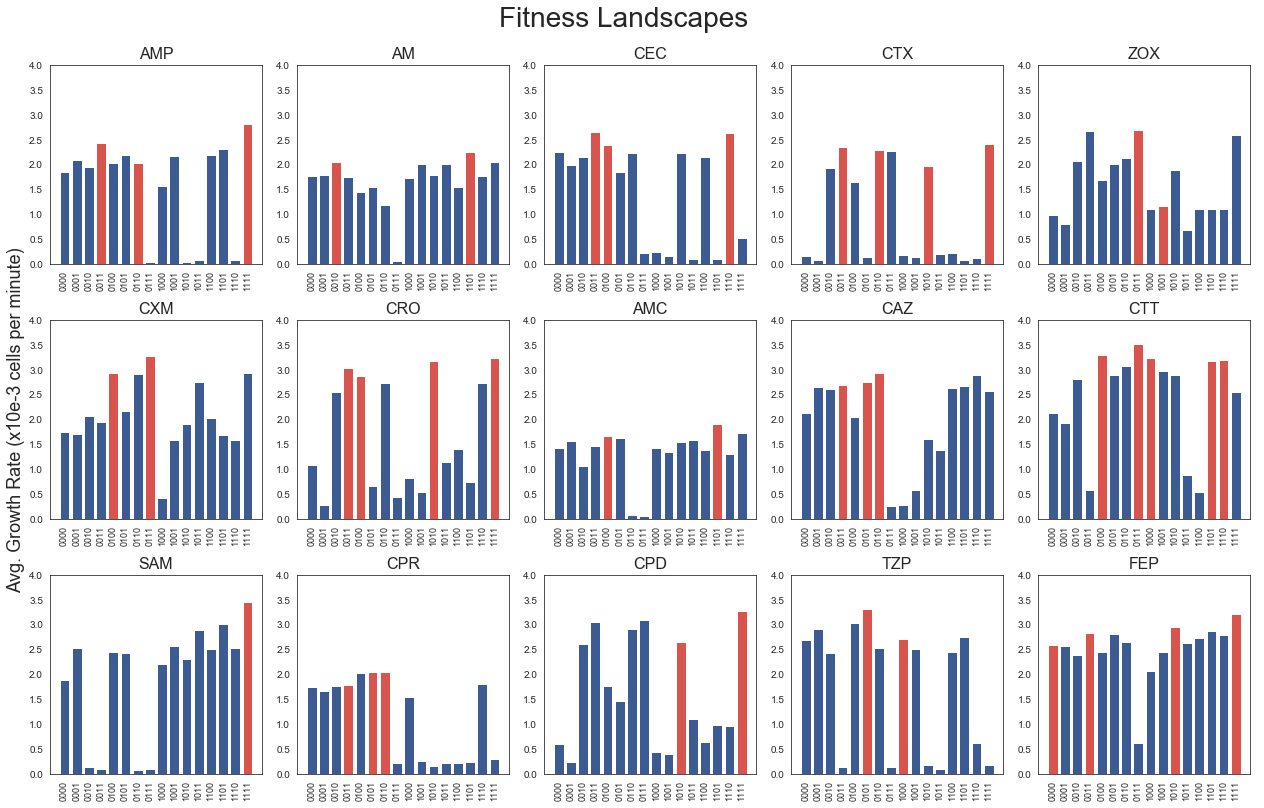

In [20]:
#==============================================================================#
# Supplementary Figure 1
#==============================================================================#
def lab(k):
    gt = convertIntToGenotype(k, 4)
    l = "".join(map(str,gt))
    return l

def col(ls, k):
    r = sns.xkcd_rgb['pale red']
    b = sns.xkcd_rgb['denim blue']
    if ls.isPeak(convertIntToGenotype(k, 4)):
        return sns.xkcd_rgb['pale red']
    else:
        return sns.xkcd_rgb['denim blue']

fig = plt.figure(figsize=(18,12))
for k, ls in enumerate(landscapes):
    plt.subplot(3,5,k+1)
    cols = map(lambda k : col(ls, k), range(2**4))
    barlist = plt.bar(range(2**4), ls.landscape, color=cols)
    plt.ylim(0.0,3.0)
    plt.title(labs[k], size=16)
    plt.xticks(range(2**4), map(lab, range(2**4)), size=9, rotation='vertical')
    plt.yticks(np.arange(0.0,4.1 ,0.5))

plt.subplots_adjust(hspace=0.6)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel("Avg. Growth Rate (x10e-3 cells per minute)", size=18)
plt.suptitle("Fitness Landscapes", size=28)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

## Collateral Sensitivity

In our exploration of collateral sensitivity, we assume that the initial population is a "wild-type" population, mirroring experimental evolution of drug resistance. As such, we specify an initial population as follows

In [10]:
# g=0000 is the initial genotype 
init_wt = np.array([1.]+[0. for i in range(15)])

To determine the collateral response under a second drug $y$, first we randomly select a fitness peak genotype ($g_x^*$) in the first landscape, $x$, arising from evolution from the initial genotype $g_0$. Next, the collateral response is calculated as

$\text{Collateral response of $Y$ to $X$} = \log_2\left( \frac{f_y(g_x^*)}{f_y(g_0)} \right)$

In [11]:
#==============================================================================#
# Plotting functions used to display a table of collateral response
#==============================================================================#
# Displays the matrix/heatmap
def show_CSN(csmat):
    fig = plt.figure(figsize=(5.3,4.5))
    ax = fig.add_subplot(111)
    cax=ax.matshow(csmat, cmap = plt.cm.RdBu_r, vmin = -5, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_ticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
    cbar.ax.set_yticklabels(['32x','16x','8x','4x','2x','1x',
                             '2x','4x','8x','16x','32x'])
    cbar.set_label('Change from wild-type sensitivity', size=14)

    ax.set_xticks(range(len(labs)))
    ax.set_yticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=45, size=12)
    ax.set_yticklabels(labs, size=12)
    ax.axis('image')

    ax.set_xlabel('First drug', size=16)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Second drug', size=16)

# Displays a bar chart of showing number of CS/CR drug pairs
def bar_comparison(csmat):
    bets, wors = [],[]
    for d2 in range(len(landscapes)):
        row = np.array(csmat).T[d2]
        bets.append(sum(map(lambda x : x<-10**(-8), row)))
        wors.append(sum(map(lambda x : x>10**(-8), row)))

    bets = map(lambda x : -x, bets)
    cmap = plt.cm.RdBu

    res_bar_col = cmap(0.1)
    sen_bar_col = cmap(0.9)

    fig, ax = plt.subplots(figsize=(5,5))
    ax = plt.subplot(1,2,1)
    rects1 = ax.barh(np.arange(len(landscapes)), wors, color=res_bar_col)
    rects2 = ax.barh(np.arange(len(landscapes)), bets, color=sen_bar_col)
    plt.xlim(-15,15)
    plt.ylim(-1,15)
    plt.xticks([-15,-10,-5,0,5,10,15])
    ax.set_xticklabels([15,10,5,0,5,10,15], size=12)
    plt.xlabel('Number of second drugs', size=16)
    plt.ylabel('First drug', size=16)
    plt.yticks(np.arange(0.0,len(landscapes)+0.0,1.0), labs)
    plt.axvline(0., lw=1.0, ls='-', c='k')
    
    for v in [-10,-5,5,10]:
        plt.axvline(v, lw=0.3, ls='-', c='k', zorder=0)


    plt.gca().invert_yaxis()

### Simulating a table of collateral response with one replicate per drug pair

In [12]:
#==============================================================================#
# Simulates a single instance of determining collateral sensitivity
#
# As evolution is not necessarily repeatable, this is not guaranteed to generate
# the same matrix of collateral sensitivity on each instance.
#==============================================================================#
def col_sensitivity(d1, d2, init_pop, relative=True):
    limit_d1 = limit_matrices[d1]
    pop_dist = init_pop * limit_d1
    pop_dist = np.array(pop_dist)[0]
    peak = np.random.choice(np.array([i for i in range(16)]), p=pop_dist)
    
    f_evolved = landscapes[d2].getFitness(convertIntToGenotype(peak,4))
    f_wt = landscapes[d2].getFitness(convertIntToGenotype(0,4))
    
    col_sens = np.log2(f_evolved / f_wt)
    return col_sens

def generateCSN(init_pop):
    network = [[col_sensitivity(d1,d2,init_pop) for d1 in range(len(landscapes))] 
               for d2 in range(len(landscapes))]
    return network


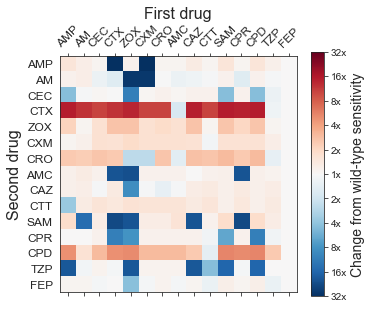

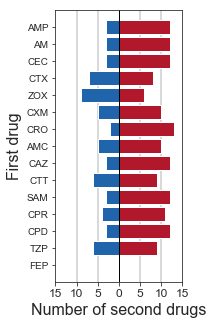

In [13]:
#==============================================================================#
# Example use.
#==============================================================================#
example_csn = generateCSN(init_wt)
with sns.axes_style("white"):
    show_CSN(example_csn)
    
with sns.axes_style("ticks"):
    bar_comparison(example_csn)

### Exploring the space of collateral sensitivity tables
The following methods are used to explore the space of collateral sensitivity tables to find the most likely outcome along with the best-case, worst-case and average-case outcome for a table of collateral sensitivity determined from a single round of experimental evolution.

In [14]:
#==============================================================================#
# Determines the most likely CSM and the associated probability
#==============================================================================#
def most_likely(init_pop):
    gs,ps = [],[]
    for d in range(15):
        limit = limit_matrices[d]
        pop_dist = np.array(init_pop * limit)[0]
        g = np.argmax(pop_dist)
        gs.append(g)
        ps.append(pop_dist[g])

    network = [[np.log2(landscapes[d2].getFitness(convertIntToGenotype(g,4)) \
                        /landscapes[d2].getFitness(convertIntToGenotype(0,4))) \
                for g in gs] \
                for d2 in range(15)]
    p = np.product(ps)
    return p,network

#==============================================================================#
# Determines the best and worst case outcome by means of multiple
# trials.
#==============================================================================#
def worst_mat(init_pop):
    def worst_outcome(d1,d2,init_pop):
        limit_d1 = limit_matrices[d1]
        pop_dist = init_pop * limit_d1
        pop_dist = np.array(pop_dist)[0]

        wt_f = landscapes[d2].getFitness([0,0,0,0])
        
        #Determine the highest fitness outcome.
        worst_f = -np.inf
        for i in range(len(pop_dist)):
            if pop_dist[i] > 10**(-8): #If its possible
                i_f = landscapes[d2].getFitness(convertIntToGenotype(i,4))
                if  i_f > worst_f:
                    worst_f = i_f 
        
        return np.log2(worst_f/wt_f)
    
    mat =[[worst_outcome(d1,d2,init_pop) \
               for d1 in range(len(landscapes))] \
            for d2 in range(len(landscapes))]
    return mat


def best_mat(init_pop):
    def best_outcome(d1,d2,init_pop):
        limit_d1 = limit_matrices[d1]
        pop_dist = init_pop * limit_d1
        pop_dist = np.array(pop_dist)[0]

        wt_f = landscapes[d2].getFitness([0,0,0,0])
        
        #Determine the highest fitness outcome.
        best_f = np.inf
        for i in range(len(pop_dist)):
            if pop_dist[i] > 10**(-8): #If its possible
                i_f = landscapes[d2].getFitness(convertIntToGenotype(i,4))
                if  i_f < best_f:
                    best_f = i_f 
        
        return np.log2(best_f/wt_f)
    
    mat =[[best_outcome(d1,d2,init_pop) \
               for d1 in range(len(landscapes))] \
            for d2 in range(len(landscapes))]
    return mat

#==============================================================================#
# Determines the average collateral response for each drug pair
#==============================================================================#
def expected_network(init_pop):
    
    def expected_sensitivity(d1,d2,init_pop):
        limit_d1 = limit_matrices[d1]
        pop_dist = init_pop * limit_d1
        pop_dist = np.array(pop_dist)[0]
        
        expected_evo_f = sum([pop_dist[i] * landscapes[d2].getFitness(convertIntToGenotype(i,4)) \
                                   for i in range(16)])
        wt_f = landscapes[d2].getFitness(convertIntToGenotype(0,4))
        
        expected_fitness = np.log2(expected_evo_f/wt_f)
        return expected_fitness
    
    network =[[expected_sensitivity(d1,d2,init_pop) \
               for d1 in range(len(landscapes))] \
            for d2 in range(len(landscapes))]
    return network

In [15]:
exp = worst_mat(init_wt)
exp = np.array(exp).T
for ix,row in enumerate(exp):
    print labs[ix],(np.array(row)>0).sum(), (np.array(row)<0).sum()

AMP 14 1
AM 14 1
CEC 12 3
CTX 14 1
ZOX 8 7
CXM 12 3
CRO 15 0
AMC 15 0
CAZ 14 1
CTT 14 1
SAM 12 3
CPR 14 1
CPD 12 3
TZP 12 3
FEP 0 0


The most likely CSM occurs with probability:  0.0022921905959457397


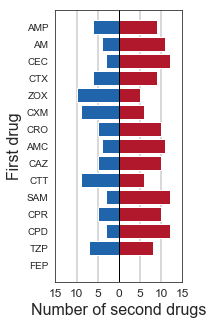

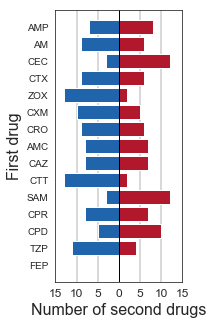

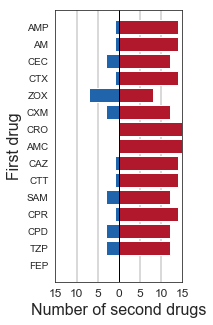

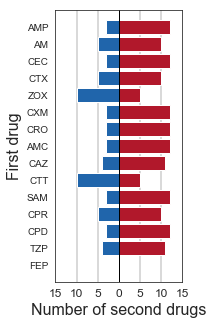

In [16]:
#==============================================================================#
# Generating Figure 2:
#==============================================================================#
exp  = expected_network(init_wt)
# best, worst = best_and_worst(1000, init_wt)
worst = worst_mat(init_wt)
best  = best_mat(init_wt)
p,net = most_likely(init_wt)
print "The most likely CSM occurs with probability: ", p

directory = './figs'
if not os.path.exists(directory):
    os.makedirs(directory)

# Uncomment below to build the parts of Figure 2
# show_CSN(exp) 
# plt.savefig('./figs/expected_hm2.svg')
bar_comparison(exp)
plt.savefig('./figs/expected_bars.svg')
# show_CSN(best)
# plt.savefig('./figs/best_hm2.svg')
bar_comparison(best)
plt.savefig('./figs/best_bars.svg')
# show_CSN(worst)
# plt.savefig('./figs/worst_hm2.svg')
bar_comparison(worst)
plt.savefig('./figs/worst_bars.svg')
# show_CSN(net)
# plt.savefig('./figs/ml_hm2.svg')
bar_comparison(net)
plt.savefig('./figs/ml_bars.svg')

### Simulating experimental evolution to find CS drugs
In the manuscript we ask the following two questions:
1. What is the probability that a randomly chosen the drug pair exhibits cross resistance?   
2. Given that a drug pair exhibits collateral sensitivity in a single simulation of experimental evolution, what is it the likelihood that it exhibits cross resistance in second such experiment?

The following functions determine the answers to these questions.

In [17]:
#==============================================================================#
# Computes the likelihood of CLR from a random drug pair
#
# Here we assume that the drug pair is chosen uniformly at random. As such, 
# the probability of choosing a CR pair at random can be determined analytically by 
# summing, over all possible pairs, the total probability mass of collateral
# resistance and then normalising appropriately.
#==============================================================================#
def random_cl():
    tot = 0.
    for d1 in range(15):
        for d2 in range(15):
            if d1!=d2:
                temp = 0
                wt_f = landscapes[d1].getFitness([0,0,0,0])
                ev_pop = init_wt * limit_matrices[d1]
                ev_pop = np.array(ev_pop)[0]
                for k in range(len(ev_pop)):
                    ev_f = landscapes[d2].getFitness(convertIntToGenotype(k,4))
                    if ev_f > wt_f:
                        temp+=ev_pop[k]
                tot+=temp
    tot = tot / (15. * 14.)
    return tot

#==============================================================================#
# Determines the probability that a pair identified as CS in a single simulation of 
# experimental evolution is CR in a second simulation.
#
# This is determined by repeatedly sampling a random matrix of collateral response,
# choosing a CS pair at random and then determining the likelihood that the first of 
# that pair induces CR in the second.
#==============================================================================#
def prob_clr():
    #generate a random csn
    csn = generateCSN(init_wt)
    #Pick a pair with CS are random
    flag = True
    while flag:
        d1 = random.randint(0,14)
        d2 = random.randint(0,14)
        if csn[d1][d2] < 0.0:
            flag = False

    #find the probability of clr.
    prob_res = 0.0
    wt_f = landscapes[d1].getFitness([0,0,0,0])
    ev_pop = init_wt * limit_matrices[d1]
    ev_pop = np.array(ev_pop)[0]
    for k in range(len(ev_pop)):
        ev_f = landscapes[d2].getFitness(convertIntToGenotype(k,4))
        if ev_f > wt_f:
            prob_res += ev_pop[k]

    return prob_res

#10000 samples:
S = 10**3 #10**6 #In the paper
cr_ps =  np.mean([prob_clr() for _ in range(S)])

print "The probability of CR in a random pair is: ", random_cl()
print "The probability of CR in a random pair identified as CS is: ", cr_ps

The probability of CR in a random pair is:  0.5767195767195767
The probability of CR in a random pair identified as CS is:  0.50775


## Collateral Sensitivity Likelihoods
Here we derive *likelihood of collateral sensitivity* between pairs of drugs.

In [18]:
#==============================================================================#
# Given two drugs, returns the probability that evolution
# under the first results in a genotype with fitness under the
# second that is lower than the WT fitness.
#==============================================================================#
def prob_better(d1,d2,init_pop):
    limit_d1 = limit_matrices[d1]
    pop_dist = init_pop * limit_d1
    pop_dist = np.array(pop_dist)[0]

    prob = 0
    wt_f = landscapes[d2].getFitness([0,0,0,0])
    for i in range(len(pop_dist)):
        if landscapes[d2].getFitness(convertIntToGenotype(i,4)) < wt_f:
            prob+=pop_dist[i]

    return prob
#==============================================================================#
# Collateral Sensitivity Likelihood matrix
#==============================================================================#
def prob_matrix(init_pop):
    mat = [[prob_better(d1,d2,init_pop) for d1 in range(len(landscapes))] \
           for d2 in range(len(landscapes))]
    return mat

#==============================================================================#
# Plots the table of collateral sensitivity likelihood
#==============================================================================#
def show_CSL(mat):
    fig = plt.figure(figsize  = (6,5))
    ax = fig.add_subplot(111)
    cax=ax.matshow(mat, cmap = plt.cm.Greens, vmin = 0.0, vmax = 1.0)

    cbar = fig.colorbar(cax)
    cbar.set_label('Probability of collateral sensitivity', size=14)

    ax.set_xticks(range(len(labs)))
    ax.set_yticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=45, size=12)
    ax.set_yticklabels(labs, size=12)
    ax.axis('image')

    ax.set_xlabel('First drug', size='16')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Second drug', size='16')

#==============================================================================#
# Returns a CSL in which all entries <p are set to zero
#==============================================================================#
def cut_off_probs_CSL(network, p):
    new_net = [[x if p-x<=10**(-8) else 0.0 for x in y] for y in network]
    return new_net

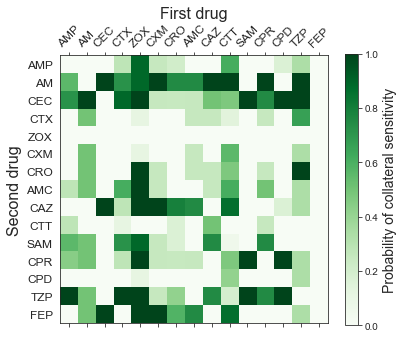

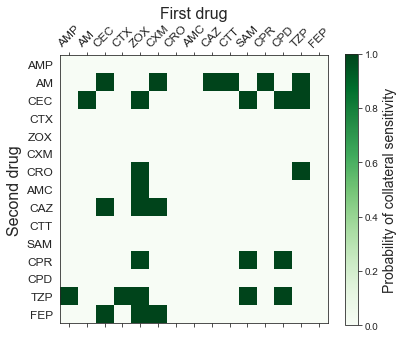

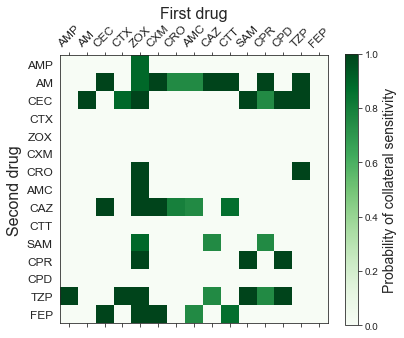

In [19]:
#==============================================================================#
# Example use. Figure 5 parts
#==============================================================================#
sns.set_style('white')
csl = prob_matrix(init_wt)
show_CSL(csl)  #Uncomment for other figures.
plt.savefig('./figs/csls.svg')
show_CSL(cut_off_probs_CSL(csl, 1.0))
plt.savefig('./figs/csls_1.svg')
show_CSL(cut_off_probs_CSL(csl, 0.75))
plt.savefig('./figs/csls_075.svg')